# fast.ai GENERATE ID

In [1]:
from fastai.collab import *
from fastai.tabular import *


#'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
#path = untar_data(URLs.ML_SAMPLE)
#print(path.ls())

ratings = pd.read_csv('ml-latest-small/ratings.csv')
all_movies =  ratings['movieId'].unique().astype(str)
all_movies_df = DataFrame(all_movies,columns=['movieId'])
all_users = ratings['userId'].unique().astype(str)
all_users_df = DataFrame(all_movies,columns=['userId'])

# save index to use as alternative
all_movies_df.index.name = 'movie_ix'
all_movies_df.to_csv('../data/movies_id.csv')

print('Number of movies:', len(all_movies),'Number of users:', len(all_users))
ratings.head()

Number of movies: 9724 Number of users: 610


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [2]:
user,title,rating = 'userId','movieId','rating'
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0, item_name=title)

#data = CollabList.from_df(ratings, cat_names=[user,title], procs=Categorify)
#data_split = data.split_by_rand_pct(valid_pct=0.2, seed=200).label_from_df(cols=rating)
#print('classes: ', len(data_split.x.classes['movieId']))
#il = data.split_by_rand_pct(valid_pct=0, seed=200)
#data_split = il.label_from_df(cols=rating)
#len(data_split.train.x.classes['movieId'])
#data_bunch = data_split.databunch()

In [3]:
y_range = [0,5.5]
#y_range_value = (y_range[1]-y_range[0])+
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

#print(len(learn.data.x.classes['movieId']))
#print(learn.data.get_emb_szs())
#print(learn.weight(all_movies,is_item=True).shape)
#print(learn.bias(all_movies,is_item=True).shape)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(611, 40)
  (i_weight): Embedding(9725, 40)
  (u_bias): Embedding(611, 1)
  (i_bias): Embedding(9725, 1)
)

# LEARN - NOT REQUIRED 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


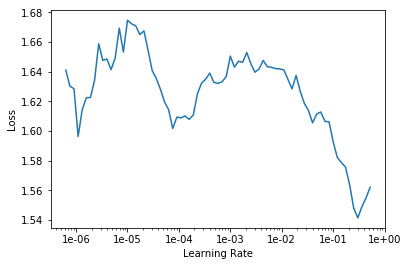

In [16]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.809372,,00:05
1,0.721826,,00:04
2,0.615980,,00:04
3,0.506279,,00:05
4,0.376298,,00:05


In [14]:
learn.fit_one_cycle(15, 5e-3)

epoch,train_loss,valid_loss,time
0,0.355649,,00:05
1,0.399756,,00:05
2,0.432609,,00:05
3,0.487330,,00:05
4,0.489273,,00:04
5,0.473474,,00:05
6,0.455817,,00:05
7,0.421054,,00:04
8,0.378137,,00:05
9,0.337703,,00:05


In [15]:
learn.save('-3')

# LOAD MODEL

In [6]:
learn.load('-3');

# Go forward function

Tutaj jest załadowane i obliczane wagi do funkcji, a takżę matrix
Na wyjściu do zapisania
- `movies_weights`
- `movies_bias`
- `user_weights`
- `user_bias`
- `matrix`

In [7]:
# learn.model.cuda()
movies_weights = learn.weight(all_movies,is_item=True)
movies_bias = torch.t(learn.bias(all_movies,is_item=True)[None])
movies_f = torch.cat([movies_bias, movies_weights],1)

user_weights = learn.weight(all_users,is_item=False)
user_bias = torch.t(learn.bias(all_users,is_item=False)[None])
user_f = torch.cat([user_weights, user_bias],1)


matrix=user_f@torch.t(movies_f)

print(movies_f.shape,user_f.shape)
print(matrix.shape)

#learn.cuda();

torch.Size([9724, 41]) torch.Size([610, 41])
torch.Size([610, 9724])


In [20]:
#%%debug

movie_ix = 34
user_ix = 0

def predict_single(movie_ix,user_ix):
    sum1 = (user_weights[user_ix]*movies_weights[movie_ix]).sum();
    sum2 = sum1+user_bias[user_ix]+movies_bias[movie_ix];
    sigm = torch.sigmoid(sum2)
    print('sum_weights:', sum1, ' with bias:', sum2, 'sigmoid:',sigm, 'result:', sigm*(y_range[1]-y_range[0])+y_range[0]);
    

def show_predicts(movie_ix,user_ix):
    movie_id =  int(all_movies[movie_ix])
    user_id = int(all_users[user_ix])

    #learn.model.cuda()


    movie_t = learn.get_idx([str(movie_id)],is_item=True).cuda() # torch.LongTensor([movie_ix+1]).cuda()   #n&a is first element
    user_t =  learn.get_idx([str(user_id)],is_item=False).cuda() # torch.LongTensor([user_ix+1]).cuda()   #n&a is first element
    
    
    # print(movie_id,movie_t,user_id ,user_t)
    print('user_ix: ', user_ix, 'movie_ix: ', movie_ix)
    print(ratings[(ratings['movieId']==movie_id) & (ratings['userId']==user_id)]); # real rating
    
    learn.model.cuda()
    print(learn.predict({'userId': user_id, 'movieId': movie_id }))  #using predict function
    print(learn.model.forward(user_t,movie_t)) #using forward function
    
    predict_single(movie_ix,user_ix)
    
    

show_predicts(movie_ix,user_ix)
print('\n')
show_predicts(movie_ix+1,user_ix)
print('\n')
show_predicts(movie_ix,user_ix+1)
print('\n')
show_predicts(movie_ix+1,user_ix+1)
print('\n')
show_predicts(movie_ix,user_ix+2)
print('\n')
show_predicts(movie_ix+1,user_ix+2)

user_ix:  0 movie_ix:  34
    userId  movieId  rating  timestamp
34       1      593     4.0  964983793
(FloatItem 4.310879, tensor(4.3109), tensor(4.3109))
tensor([4.3109], device='cuda:0')
sum_weights: tensor(0.2232)  with bias: tensor([1.2879]) sigmoid: tensor([0.7838]) result: tensor([4.3109])


user_ix:  0 movie_ix:  35
    userId  movieId  rating  timestamp
35       1      596     5.0  964982838
(FloatItem 4.646312, tensor(4.6463), tensor(4.6463))
tensor([4.6463], device='cuda:0')
sum_weights: tensor(0.8953)  with bias: tensor([1.6943]) sigmoid: tensor([0.8448]) result: tensor([4.6463])


user_ix:  1 movie_ix:  34
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []
(FloatItem 3.9020193, tensor(3.9020), tensor(3.9020))
tensor([3.9020], device='cuda:0')
sum_weights: tensor(0.3560)  with bias: tensor([0.8928]) sigmoid: tensor([0.7095]) result: tensor([3.9020])


user_ix:  1 movie_ix:  35
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []
(Flo

In [21]:
#show_predicts(movie_ix,user_ix)

users_w = user_weights[[user_ix,user_ix+1,user_ix+2]]
users_b = user_bias[[user_ix,user_ix+1,user_ix+2]]

movies_w = movies_weights[[movie_ix,movie_ix+1]]
movies_b =  movies_bias[[movie_ix,movie_ix+1]]

def forward(users_w,users_b,movies_w,movies_b):
    #print(users_w.shape,movies_w.shape)
    dot = ((users_w@torch.t(movies_w)+users_b).squeeze()+torch.t(movies_b)).squeeze()
    res = torch.sigmoid(dot)*(y_range[1]-y_range[0])+y_range[0]
    return res


forward(users_w,users_b,movies_w,movies_b)

tensor([[4.3109, 4.6463],
        [3.9020, 3.3712],
        [1.0854, 1.3866]])

In [23]:
matrix = forward(user_weights,user_bias,movies_weights,movies_bias)
print(matrix.shape)

torch.Size([610, 9724])


# Export Matrix

In [204]:
import pickle

with open('../data/movie_recommendation.pickle', 'wb') as handle: #24 megabytes, without matrix 1.6MB
    pickle.dump(
        (matrix,
         movies_weights,
         movies_bias,
         user_weights,
         user_bias), handle, protocol=pickle.HIGHEST_PROTOCOL)

# PCA (categories)

Na wyniku dostajemy zawsze movies i jeśli je łączym to trzeba wiedzieć że je łączymy po `movie_ix`. Nie zawsze w `movies_input.zip` będą wszystkie filmy które były w modelu. Ale w modelu powinny być wszystkie wartości.

In [98]:
movies = pd.read_csv('../data/movie_input.csv');
movies_id = pd.read_csv('../data/movies_id.csv');

#movies['movie_ix']
movies.tail()

,movieId,movie_ix,imdbId,tmdbId,genres,cover,title,full-title,year,director,producer,imdb_url,rating,small-cover,plot,length,youtubeId
8648,118082,9692,1567437,244458.0,"Comedy,Crime,Thriller",https://m.media-amazon.com/images/M/MV5BMTQ2NT...,The Voices,The Voices (2014),2014.0,Marjane Satrapi,1984 Private Defense Contractors,http://www.imdb.com/title/tt1567437/,6.4,https://m.media-amazon.com/images/M/MV5BMTQ2NT...,Jerry (Ryan Reynolds) is that chipper guy cloc...,103.0,3hQpV9Q0A7E
8649,129313,9694,2392672,179150.0,Comedy,https://m.media-amazon.com/images/M/MV5BMTcyND...,Reality,Reality (2014),2014.0,Quentin Dupieux,Realitism Films,http://www.imdb.com/title/tt2392672/,6.9,https://m.media-amazon.com/images/M/MV5BMTcyND...,NaN,95.0,roXp_BwRjmY
8650,130050,9695,1991031,279972.0,"Drama,Fantasy,Horror,Mystery,Thriller",https://m.media-amazon.com/images/M/MV5BMjM3ND...,Digging Up the Marrow,Digging Up the Marrow (2014),2014.0,Adam Green,ArieScope Pictures,http://www.imdb.com/title/tt1991031/,5.8,https://m.media-amazon.com/images/M/MV5BMjM3ND...,NaN,89.0,MCSYNT7Xrfs
8651,130052,9696,1780798,112454.0,"Drama,Horror",https://m.media-amazon.com/images/M/MV5BYWNkYm...,Clown,Clown (2014),2014.0,Jon Watts,Cross Creek Pictures,http://www.imdb.com/title/tt1780798/,5.7,https://m.media-amazon.com/images/M/MV5BYWNkYm...,A little boy's birthday party gets ruined when...,100.0,utmvmr7cgcg
8652,130840,9697,3395184,241855.0,"Horror,Romance,Sci-Fi",https://m.media-amazon.com/images/M/MV5BMjMwNz...,Spring,Spring (2014),2014.0,Justin Benson,Rustic Films,http://www.imdb.com/title/tt3395184/,6.7,https://m.media-amazon.com/images/M/MV5BMjMwNz...,NaN,109.0,gcoRtZkDwKA


In [99]:
print(movies_weights.shape,movies_bias.shape) #9724 movies
movies_factors = torch.cat([movies_weights,movies_bias],1)
movies_pca = torch.t(movies_factors.pca(10))

print('movies_pca.shape:', movies_pca.shape)

torch.Size([9724, 40]) torch.Size([9724, 1])
movies_pca.shape: torch.Size([10, 9724])


In [100]:
movies_fac0 = [(f, i,id) for f,i,id in zip(
    movies_pca[7, movies['movie_ix']], # tylko przefiltrowane movies po id z uczenia.
    movies['title'], 
    movies['movieId'])]
[ 
    *sorted(movies_fac0, key=itemgetter(0), reverse=True)[:10],
    *sorted(movies_fac0, key=itemgetter(0))[:10]
]

[(tensor(0.4408), 'Peggy Sue Got Married', 2469),
 (tensor(0.4392), 'How to Make an American Quilt', 46),
 (tensor(0.4338), 'Cowboy Bebop: The Movie', 6283),
 (tensor(0.3992), 'Mulholland Falls', 707),
 (tensor(0.3973), 'The Last Airbender', 78893),
 (tensor(0.3898), 'Dark City', 1748),
 (tensor(0.3764), 'The World Is Not Enough', 3082),
 (tensor(0.3757), 'Little Big Man', 3037),
 (tensor(0.3745), 'History of the World: Part I', 2301),
 (tensor(0.3741), 'Operation Petticoat', 4802),
 (tensor(-0.4859), 'The Ladykillers', 7367),
 (tensor(-0.4744), 'Panic Room', 5266),
 (tensor(-0.4700), 'The Blair Witch Project', 2710),
 (tensor(-0.4303), 'Toy Story', 1),
 (tensor(-0.4271), 'The Age of Innocence', 412),
 (tensor(-0.4175), "It's Kind of a Funny Story", 80693),
 (tensor(-0.4151), 'The Piano', 509),
 (tensor(-0.4086), 'Rebel Without a Cause', 1103),
 (tensor(-0.4058), 'Scream', 1407),
 (tensor(-0.4033), 'Meet the Parents', 3948)]

In [101]:
movies_pca_cpu = torch.t(movies_pca).cpu().detach().numpy()
print(movies_pca_cpu.shape)

(9724, 10)


In [122]:
%%time

# Importing Modules
from sklearn import datasets
from sklearn.cluster import KMeans

# Declaring Model
model = KMeans(n_clusters=5)

# Fitting Model
model.fit(movies_pca_cpu)

# Prediction on the entire data
all_predictions = model.predict(movies_pca_cpu)

# Printing Predictions
print(all_predictions.shape, all_predictions[movies['movie_ix']].shape)

movies['category'] = all_predictions[movies['movie_ix']]
movies_id['category'] = all_predictions[movies_id['movie_ix']]
print(movies[['movieId','movie_ix','title','category']].head())

movies_id.to_csv('../data/movies_category.csv',index=False)
print(movies_id.head())

(9724,) (8653,)
   movieId  movie_ix               title  category
0        1         0           Toy Story         4
1        3         1    Grumpier Old Men         4
2        6         2                Heat         2
3       47         3               Se7en         2
4       50         4  The Usual Suspects         2
   movie_ix  movieId  category
0         0        1         4
1         1        3         4
2         2        6         2
3         3       47         2
4         4       50         2
CPU times: user 1.61 s, sys: 0 ns, total: 1.61 s
Wall time: 406 ms


In [121]:
movies_fac0 = [(f, i,id) for f,i,id in zip(all_predictions[movies['movie_ix']], 
                                           movies['title'],
                                           movies['movieId'])]
[ 
    *sorted(movies_fac0, key=itemgetter(0), reverse=True)[:10],
    *sorted(movies_fac0, key=itemgetter(0))[:10]
]

[(4, 'Blown Away', 423),
 (4, 'Space Jam', 673),
 (4, "Pete's Dragon", 1030),
 (4, "McHale's Navy", 1445),
 (4, 'Con Air', 1552),
 (4, 'I Know What You Did Last Summer', 1644),
 (4, 'Toys', 2253),
 (4, 'I Still Know What You Did Last Summer', 2338),
 (4, 'Psycho', 2389),
 (4, 'Howard the Duck', 2450),
 (0, 'From Dusk Till Dawn', 70),
 (0, 'Canadian Bacon', 157),
 (0, 'Billy Madison', 216),
 (0, 'The Mask', 367),
 (0, "She's the One", 804),
 (0, 'Escape to Witch Mountain', 1009),
 (0, 'The Three Caballeros', 1024),
 (0, 'That Thing You Do!', 1042),
 (0, 'Batman Returns', 1377),
 (0, 'Best Men', 1473)]

# get_movies_cold()

In [178]:
movies = pd.read_csv('../data/movie_input.csv');
movies['category'].value_counts() # each category and values connected to

0    3583
3    1817
1    1537
4     944
2     772
Name: category, dtype: int64

In [195]:
def get_sample(cat, n=5,head=100, min_cnt=20):
    return movies[(movies['category']==cat) & (movies['cnt']>min_cnt) ].sort_values(by='rating',ascending=False).head(head).sample(n)

print('sample size of each category:')

for i in range(5):
    s = get_sample(i,5)
    print('\nSample ',i,': ', len(s))
    print(s['title'])

sample size of each category:

Sample  0 :  5
487     Ace Ventura: When Nature Calls
266      Star Trek: The Motion Picture
1683           Pee-wee's Big Adventure
654          Robin Hood: Men in Tights
1584                     Arachnophobia
Name: title, dtype: object

Sample  1 :  5
1262                  Hancock
846           Die Another Day
1357    Beverly Hills Cop III
3510      Weekend at Bernie's
987               Deep Impact
Name: title, dtype: object

Sample  2 :  5
387                                     Life Is Beautiful
28                                       Schindler's List
717     Dr. Strangelove or: How I Learned to Stop Worr...
1020                                               Aliens
1104                                               Amélie
Name: title, dtype: object

Sample  3 :  5
380                 The Jerk
579     Natural Born Killers
198               Spaceballs
1514        The Dark Crystal
1978                Coraline
Name: title, dtype: object

Sample  4 :  5
76

In [197]:
# return random maximum number of movies for each of 5 categories done by pca
def get_movies_cold(): # 20 elements
    return pd.concat([
        get_sample(0,5),
        get_sample(1,5),
        get_sample(2,5),
        get_sample(3,5),
        get_sample(4,5),
    ],ignore_index=True)

get_movies_cold()['title']

0                                 The Jewel of the Nile
1                                         The Rocketeer
2                        How the Grinch Stole Christmas
3                                        101 Dalmatians
4                                            Milk Money
5                                           Van Helsing
6                                            Disclosure
7                    National Treasure: Book of Secrets
8                                                  Hulk
9                                     Final Destination
10                           Terminator 2: Judgment Day
11                The Lord of the Rings: The Two Towers
12    Dr. Strangelove or: How I Learned to Stop Worr...
13           Star Wars: Episode VI - Return of the Jedi
14                                   Back to the Future
15                                      Good Bye Lenin!
16                                      The Crying Game
17                                  The Hudsucke

# get recommendations

In [334]:
def get_all_movies():
    movies = pd.read_csv('../data/movie_input.csv');
    movies.index = movies['movie_ix']
    return movies

movies = get_all_movies()
y_range=[0.5,5.5]

with open('../data/movie_recommendation.pickle', 'rb') as handle:
    (matrix,
     movies_weights,
     movies_bias,
     user_weights,
     user_bias) = pickle.load(handle)

def forward(users_w,users_b,movies_w,movies_b):
    #print(users_w.shape,movies_w.shape)
    dot = ((users_w@torch.t(movies_w)+users_b).squeeze()+torch.t(movies_b)).squeeze()
    res = torch.sigmoid(dot)*(y_range[1]-y_range[0])+y_range[0]
    return res


def get_movies_recommendations(lists, n = 20): #movie_ix, rating
    global matrix, user_weights, user_bias, movies_bias,movies_weights, movies
    
    lists = np.array(sorted(lists, key=lambda a_entry: a_entry[0]))  #sortowanie po movieId
    movie_ixs = lists[:,0]
    movie_ratings=lists[:,1]
    
    # 2. filtrowanie po zaznaczonych listach, matrix zawiera już oceny dla wsystkich użytkowników
    reduced_matrix=matrix[:,movie_ixs] 
    
    # 3. Obliczamy pearson-a
    from scipy.stats.stats import pearsonr
    
    pearsons = np.array([])
    for ind, i in enumerate(reduced_matrix):
        #print(i, pearsonr(movie_ratings,i.numpy()), pearsonr(movie_ratings,i.numpy())[0])
        p_coeff=pearsonr(movie_ratings,i.numpy())[0]
        pearsons=np.append(pearsons,p_coeff)
    
    # 4. Pobieramy top 10 użytkowników i jego macierze
    top10_users=np.argsort(pearsons)[-10:]
    reduced_users_matrix_weights=user_weights[top10_users] # 10x40
    reduced_users_matrix_bias=user_bias[top10_users] # 10x1
    # print(reduced_users_matrix_weights.shape,reduced_users_matrix_bias.shape)
    
    # 5. Obliczamy średnio wektor dla użytkownia
    mean_vec_weights=reduced_users_matrix_weights.mean(0)[None] # 1x40
    mean_vec_bias=reduced_users_matrix_bias.mean(0)[None]       # 1x1
    
    # 6. forward
    result = forward(mean_vec_weights, mean_vec_bias, movies_weights, movies_bias)
    
    # 7. top 30 films, we will get 50 best movies and random sample 
    size = (len(movie_ixs)+n+50)
    sample_size = (len(movie_ixs)+n)
    top40_films=result.argsort(0,descending=True)[:size].numpy()[np.random.choice(size,sample_size)]
    #print(top40_films, movies.loc[top40_films]['title'], result[result.argsort(0,descending=True)])
    
    # 8. get top 20 movies (n=20)
    #print(top40_films.isin(movie_ixs))# .loc[top40_films].loc[movie_ixs]['movie_ix'])
    
    # top20=top40_films[movie_ixs];
    top20 = np.array([],int)
    for ix in top40_films:
        if len(top20)>=n: break
        if ix not in movie_ixs:
            top20=np.append(top20, ix)
    
    return  movies.loc[top20]
    
lists = np.array([[1,5],[87,2],[23,1],[13,3]]) # (kx1), movieId zaczyna od 1, czyli filtrujemy indexach macierzy
movies_filtered = get_movies_recommendations(lists)

print(movies_filtered[['movie_ix','title']])

          movie_ix                     title
movie_ix                                    
587            587                  Outbreak
238            238           The Dark Knight
444            444                   Memento
944            944          The Intouchables
219            219                 Gladiator
1774          1774        The Sound of Music
232            232  The Shawshank Redemption
3498          3498           Cinema Paradiso
887            887              The Notebook
322            322                   Aladdin
877            877             Love Actually
1051          1051              The Prestige
934            934         The King's Speech
147            147        American History X
430            430              Billy Elliot
32              32        Dances with Wolves
944            944          The Intouchables
2735          2735        Dallas Buyers Club
83              83               The Shining
232            232  The Shawshank Redemption
